I figured out the problem was that the expected mass in cylinders calculation was assuming PBC. I'm gonna have to actually compute the total mas in random cylinders. I'm gonna develop that here, as well as whatever I have to do for wp and cic. 

In [1]:
import numpy as np
from glob import glob
from os import path

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [3]:
#from pearce.mocks.kittens import DarkSky
from pearce.mocks.kittens import TestBox
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from collections import OrderedDict
from time import time
import yaml

In [4]:
output_dir = './'# '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [5]:
config_fname = 'xi_cosmo_trainer.yaml'

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [6]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [7]:
def total_mass_enclosed_per_cylinder(centers, particles,
        particle_masses, downsampling_factor, rp_bins, period,
        num_threads=1, approx_cell1_size=None, approx_cell2_size=None):

#  Perform bounds-checking and error-handling in private helper functions
    #print period
    args = (centers, particles, particle_masses, downsampling_factor,
        rp_bins, period, num_threads)
    result = _enclosed_mass_process_args(*args)
    centers, particles, particle_masses, downsampling_factor, \
        rp_bins, period, num_threads, PBCs = result


    mean_particle_mass = np.mean(particle_masses)
    normalized_particle_masses = particle_masses/mean_particle_mass

    # Calculate M_tot(< Rp) normalized with internal code units
    total_mass_per_cylinder = weighted_npairs_per_object_xy(centers, particles,
        normalized_particle_masses, rp_bins,
        period=None, num_threads=num_threads, #try large finite PBCs
        approx_cell1_size=approx_cell1_size,
        approx_cell2_size=approx_cell2_size)

    # Renormalize the particle masses and account for downsampling
    total_mass_per_cylinder *= downsampling_factor*mean_particle_mass

    return total_mass_per_cylinder


In [8]:
from halotools.mock_observables.surface_density.surface_density_helpers import rho_matter_comoving_in_halotools_units as rho_m_comoving
from halotools.mock_observables.surface_density.surface_density_helpers import annular_area_weighted_midpoints
from halotools.mock_observables.surface_density.surface_density_helpers import log_interpolation_with_inner_zero_masking as log_interp
from halotools.mock_observables import return_xyz_formatted_array

In [9]:
from halotools.mock_observables.surface_density.delta_sigma import _delta_sigma_precomputed_process_args

In [10]:
from halotools.mock_observables.surface_density.mass_in_cylinders import _enclosed_mass_process_args
from halotools.mock_observables.surface_density.weighted_npairs_per_object_xy import weighted_npairs_per_object_xy

In [11]:
def delta_sigma(galaxies, mass_enclosed_per_galaxy,
                mass_enclosed_per_random, period,
                rp_bins, cosmology):
    
    #  Perform bounds-checking and error-handling in private helper functions
    args = (galaxies, mass_enclosed_per_galaxy, rp_bins, period)
    result = _delta_sigma_precomputed_process_args(*args)
    galaxies, mass_enclosed_per_galaxy, rp_bins, period, PBCs = result

    total_mass_in_stack_of_cylinders = np.sum(mass_enclosed_per_galaxy, axis=0)

    total_mass_in_stack_of_annuli = np.diff(total_mass_in_stack_of_cylinders)

    mean_rho_comoving = rho_m_comoving(cosmology)
    mean_sigma_comoving = mean_rho_comoving*float(period[2])

    expected_mass_in_random_stack_of_cylinders = np.sum(mass_enclosed_per_random, axis = 0 )
    expected_mass_in_random_stack_of_annuli = np.diff(expected_mass_in_random_stack_of_cylinders)
    
    one_plus_mean_sigma_inside_rp = mean_sigma_comoving*(
        total_mass_in_stack_of_cylinders/expected_mass_in_random_stack_of_cylinders)

    one_plus_sigma = mean_sigma_comoving*(
        total_mass_in_stack_of_annuli/expected_mass_in_random_stack_of_annuli)

    rp_mids = annular_area_weighted_midpoints(rp_bins)
    one_plus_mean_sigma_inside_rp_interp = log_interp(one_plus_mean_sigma_inside_rp,
        rp_bins, rp_mids)

    excess_surface_density = one_plus_mean_sigma_inside_rp_interp - one_plus_sigma
    return excess_surface_density


In [12]:
def calc_ds(cat, rp_bins, randoms, tm_gal = None, tm_rand = None):
    n_cores = 4
    
    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
    pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)

    x_m, y_m, z_m = [cat.halocat.ptcl_table[c] for c in ['x', 'y', 'z']]
    pos_m = return_xyz_formatted_array(x_m, y_m, z_m, period=cat.Lbox)
    
    pos_r = randoms
    print 'A'
    if tm_gal is None:
        tm_gal = total_mass_enclosed_per_cylinder(pos_g/cat.h, pos_m/cat.h,
        cat.pmass/cat.h, 1./cat._downsample_factor, rp_bins, cat.Lbox/cat.h,
        num_threads=n_cores)
    print 'B'
    if tm_rand is None:
        tm_rand = total_mass_enclosed_per_cylinder(pos_r/cat.h, pos_m/cat.h,
        cat.pmass/cat.h, 1./cat._downsample_factor, rp_bins, cat.Lbox/cat.h,
        num_threads=n_cores)
    print 'C'
    return delta_sigma(pos_g / cat.h, tm_gal, tm_rand, 
                   cat.Lbox / cat.h, rp_bins,  cosmology=cat.cosmology)/(1e12), tm_gal, tm_rand


In [13]:
cat = TestBox(boxno = 0, realization = 0, system = 'sherlock')
cat.load(1.0, HOD='zheng07', particles = True, downsample_factor = 1e-2)

In [14]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
N = 10
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [15]:
cat.populate(hod_dicts[1])

In [16]:
rp_bins = np.logspace(-1.0, 1.6, 19)

In [18]:
N_rand = len(cat.model.mock.galaxy_table)
randoms = np.random.rand(int(N_rand), 3)*cat.Lbox

In [20]:
ds_new, tm_gal, tm_rand = calc_ds(cat, rp_bins, randoms)#, tm_gal=tm_gal)

A
B
C


In [21]:
ds_old = cat.calc_ds(rp_bins, n_cores = 1)

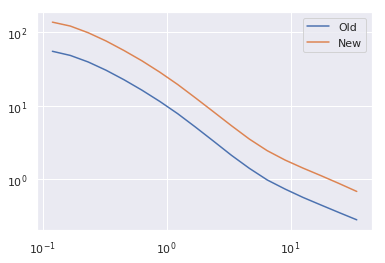

In [22]:
rpoints = (rp_bins[1:] + rp_bins[:-1])/2.0
plt.plot(rpoints, ds_old.squeeze(), label = 'Old')
plt.plot(rpoints, ds_new.squeeze(), label = 'New')


plt.legend(loc='best')
plt.loglog();

In [23]:
ds_new/ds_old

array([ 2.49332878,  2.5110502 ,  2.50055693,  2.50203491,  2.49958314,
        2.50942419,  2.5031821 ,  2.49722431,  2.4981175 ,  2.50982378,
        2.52905288,  2.50266926,  2.50395902,  2.48339274,  2.50756151,
        2.51002336,  2.48726496,  2.43350357])

In [24]:
tm_gal[0]

array([  1.82146297e+13,   3.03577161e+13,   3.64292594e+13,
         7.89300620e+13,   9.71446917e+13,   1.21430865e+14,
         1.76074754e+14,   2.91434075e+14,   4.61437285e+14,
         8.37872966e+14,   1.56038661e+15,   3.01755698e+15,
         6.44190737e+15,   1.22280881e+16,   2.35333016e+16,
         4.44072672e+16,   8.29312090e+16,   1.53306467e+17,
         2.90183337e+17])

In [25]:
tm_rand[0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.21430865e+13,   3.64292594e+13,   6.07154323e+13,
         1.45717037e+14,   2.73219445e+14,   5.46438891e+14,
         9.35017657e+14,   1.68788902e+15,   3.10863013e+15,
         5.89546848e+15,   1.15662899e+16,   2.11350420e+16,
         4.12864940e+16,   8.16561849e+16,   1.60337314e+17,
         3.05811489e+17])